# Vizualize coloc in images

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
import histlib.erastar as eras
import histlib.stress_to_windterm as stw

from histlib.cstes import labels, zarr_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Load data

In [5]:
from histlib.matchup import matchup_dataset_one
l = labels[0]
dsm = matchup_dataset_one(l, T=None, cutoff=None)
ds_eras = xr.open_zarr(zarr_dir+'_ok/erastar/erastar_'+l+'.zarr')[['es_alti_matchup_taue', 'es_alti_matchup_taun','es_drifter_matchup_taue', 'es_drifter_matchup_taun',]]
ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr').isel(alti_time =slice(80,-80))
ds_aviso =  xr.open_zarr(zarr_dir+'_ok/aviso/aviso_'+l+'.zarr')

In [6]:
def cst_rio_z15_currents(taue, taun,f, theta_lon, theta_lat, rot=True):
    theta15 = - 48.18 * np.pi / 180 * np.sign(f)
    beta15 = 0.25
    
    uek_e = beta15 * (np.cos(theta15) * taue - np.sin(theta15) * taun)
    uek_n = beta15 * (np.sin(theta15) * taue + np.cos(theta15) * taun)

    if rot:
        uek_x, uek_y = box.vevn2vxvy(theta_lon, theta_lat, uek_e, uek_n)
        return uek_x, uek_y
    else:
        return uek_e, uek_n

In [7]:
ds_data

<xarray.Dataset>
Dimensions:                                       (obs: 43073, alti_time: 51,
                                                   alti_time_mid: 210,
                                                   box_y: 80, box_x: 120,
                                                   site_obs: 1489)
Coordinates: (12/20)
    alti_lat                                      (obs, alti_time) float64 dask.array<chunksize=(500, 51), meta=np.ndarray>
    alti_lon                                      (obs, alti_time) float64 dask.array<chunksize=(500, 51), meta=np.ndarray>
  * alti_time                                     (alti_time) int64 80 ... 130
    alti_time_                                    (obs, alti_time) datetime64[ns] dask.array<chunksize=(5385, 1), meta=np.ndarray>
  * alti_time_mid                                 (alti_time_mid) float64 0.5...
    alti_x                                        (obs, alti_time) float64 dask.array<chunksize=(500, 51), meta=np.ndarray>
    ...                                            ...
    drifter_x                                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    lat                                           (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                                           (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
  * obs                                           (obs) int64 0 1 ... 43072
    time                                          (obs) datetime64[ns] dask.array<chunksize=(21537,), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables: (12/68)
    __site_id                                     (obs) object dask.array<chunksize=(21537,), meta=np.ndarray>
    __site_matchup_indice                         (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    __site_name                                   (obs) object dask.array<chunksize=(21537,), meta=np.ndarray>
    alti___distance                               (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___source                                 (obs) object dask.array<chunksize=(21537,), meta=np.ndarray>
    alti___source_center_index                    (obs) object dask.array<chunksize=(21537,), meta=np.ndarray>
    ...                                            ...
    drifter_typedeath                             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_ve                                    (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vn                                    (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vx                                    (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vy                                    (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    f                                             (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-3__gps
    __time_coverage_end:    2020-05-01T00:00:00
    __time_coverage_start:  2020-01-01T00:00:00

## Visualize the whole colocalization

In [73]:
def plot_coloc_matchup(label, nobs, dsm=dsm, ds_eras=ds_eras, ds_aviso=ds_aviso, ds_data=ds_data, figsize =(10,6), scaleera=1):
    #dataset
    _dsm = dsm.sel(obs=nobs).compute()
    dsoe = ds_eras.sel(obs=nobs).compute()
    dsdo = ds_data.sel(obs=nobs).compute()
    dsoa = ds_aviso.sel(obs=nobs).drop(['drifter_x', 'drifter_y','drifter_time']).compute()
    
    ## add ekman currents
    dsoe['es_drifter_matchup_ue'], dsoe['es_drifter_matchup_un'] = cst_rio_z15_currents(dsoe.es_drifter_matchup_taue, dsoe.es_drifter_matchup_taun, dsdo.f, dsdo.drifter_theta_lon.isel(site_obs=dsdo.__site_matchup_indice), dsdo.drifter_theta_lat.isel(site_obs=dsdo.__site_matchup_indice), rot=False)
    dsoe['es_drifter_matchup_ux'], dsoe['es_drifter_matchup_uy'] = cst_rio_z15_currents(dsoe.es_drifter_matchup_taue, dsoe.es_drifter_matchup_taun, dsdo.f, dsdo.drifter_theta_lon.isel(site_obs=dsdo.__site_matchup_indice), dsdo.drifter_theta_lat.isel(site_obs=dsdo.__site_matchup_indice), rot=True)
    dsoe['es_alti_matchup_ue'], dsoe['es_alti_matchup_un'] = cst_rio_z15_currents(dsoe.es_alti_matchup_taue, dsoe.es_alti_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=False)
    dsoe['es_alti_matchup_ux'], dsoe['es_alti_matchup_uy'] = cst_rio_z15_currents(dsoe.es_alti_matchup_taue, dsoe.es_alti_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=True)

    ## add ekman force in e,n
    dsoe['es_drifter_matchup_wd_e'], dsoe['es_drifter_matchup_wd_n'] = -dsdo.f*dsoe.es_drifter_matchup_un, dsdo.f*dsoe.es_drifter_matchup_ue
    dsoe['es_drifter_matchup_wd_x'], dsoe['es_drifter_matchup_wd_y'] = -dsdo.f*dsoe.es_drifter_matchup_uy, dsdo.f*dsoe.es_drifter_matchup_ux
    dsoe['es_alti_matchup_wd_e'], dsoe['es_alti_matchup_wd_n'] = -dsdo.f*dsoe.es_alti_matchup_un, dsdo.f*dsoe.es_alti_matchup_ue
    dsoe['es_alti_matchup_wd_x'], dsoe['es_alti_matchup_wd_y'] = -dsdo.f*dsoe.es_alti_matchup_uy, dsdo.f*dsoe.es_alti_matchup_ux
    
    ## add taux, tauy
    _ds = xr.merge([dsoe.drop(['drifter_lon', 'drifter_lat', 'drifter_time', 'drifter_x', 'drifter_y','box_x', 'box_y']), dsdo, dsoa])

    lon, lat, t_matchup = float(_dsm.lon), float(_dsm.lat), _dsm.time.values
    td = pd.to_datetime(t_matchup)
    dt = float(_ds["alti___time_difference"])
    dl = float(_ds["alti___distance"])
    
    #figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))
    land_feature = cfeature.LAND

    # aviso
    min_=_ds["aviso_box_adt"].min()
    max_=_ds["aviso_box_adt"].max()
    if min_>0 : cmap='Reds'
    elif max_<0 : cmap='Blues'
    else : cmap='bwr'
    
    C=ax.contourf(_ds.box_lon, _ds.box_lat, _ds.aviso_box_adt, levels=30, cmap=cmap,transform=crs)
    

    #axes
    lonc, latc=_ds.box_lonc,_ds.box_latc
    ax_y=_ds.sel(box_x=0, box_y=100000)[['box_lon', 'box_lat']].compute()
    ax_x=_ds.sel(box_x=200000, box_y=0)[['box_lon', 'box_lat']].compute()
    x_lon, x_lat= ax_x.box_lon,ax_x.box_lat
    y_lon, y_lat= ax_y.box_lon,ax_y.box_lat
    
    ax.arrow(lonc,latc, y_lon-lonc, y_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ax.arrow(lonc,latc, x_lon-lonc, x_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ax.text(y_lon+0.5, y_lat,'Y',transform=crs, fontsize=15)
    ax.text(x_lon+0.5, x_lat,'X',transform=crs, fontsize=15)

    # drifter
    ax.scatter(_ds["drifter_lon"], _ds["drifter_lat"], c=np.arange(1, len(_ds["drifter_lat"].values)+1),cmap='viridis_r', marker='.',s=3, transform=crs, label="drifter's trajectory")
    ax.plot(_ds["drifter_lon"][0], _ds["drifter_lat"][0], "o", ms=5, color="y", transform=crs, label='start')
    ax.plot(_ds["drifter_lon"][-1], _ds["drifter_lat"][-1], "o", ms=10, color="navy", transform=crs, label='end')

    ax.plot(_dsm["drifter_lon"], _dsm["drifter_lat"], 
            "*", ms=20, color="g", lw=2, transform=crs, label="drifter's matchup point")
    #eras
    ax.quiver(np.array([_dsm["drifter_lon"],_ds["alti_lon"][25]]), np.array([_dsm["drifter_lat"],_ds["alti_lat"][25]]), np.array([_ds['es_drifter_matchup_taue'],_ds['es_alti_matchup_taue']]), np.array([_ds['es_drifter_matchup_taun'],_ds['es_alti_matchup_taun']]),
            color='mediumvioletred',transform=crs, lw=3, label='Wind stress from ERA star',scale=scaleera, width=0.01, zorder=4)
    #ax.quiver(np.array([_dsm["drifter_lon"],_ds["alti_lon"][45]]), np.array([_dsm["drifter_lat"],_ds["alti_lat"][45]]), np.array([_ds['es_drifter_matchup_ue'],_ds['es_alti_matchup_ue']]), np.array([_ds['es_drifter_matchup_un'],_ds['es_alti_matchup_un']]),
    #         color='white',transform=crs, lw=3, label='Ekman current from ERA star', zorder=4)#scale=1e10, width=0.01,
    #ax.quiver(np.array([_dsm["drifter_lon"],_ds["alti_lon"][45]]), np.array([_dsm["drifter_lat"],_ds["alti_lat"][45]]), np.array([_ds['es_drifter_matchup_wd_e'],_ds['es_alti_matchup_wd_e']]), np.array([_ds['es_drifter_matchup_wd_n'],_ds['es_alti_matchup_wd_n']]),
    #         color='y',transform=crs, lw=3, label='Ekman acceleration from ERA star', zorder=4)#scale=1e10, width=0.01,
    
    # altimetry
    ax.scatter(_ds["alti_lon"], _ds["alti_lat"], s=np.arange(1, len(_ds["alti_lon"].values)+1)*0.2, color="orange", transform=crs, label= "satelitte's track")
    ax.plot(_ds["alti_lon"][0], _ds["alti_lat"][0], ".", ms=5, color="orange", transform=crs, label='start')
    ax.plot(_ds["alti_lon"][-1], _ds["alti_lat"][-1], ".", ms=20, color="orange", transform=crs,label='end')
    ax.plot(_ds["alti_lon"][25], _ds["alti_lat"][25], "*", ms=20, color="darkorange", lw=2, transform=crs, label="altimeter's matchup point")
    
    gl = ax.gridlines(draw_labels=True, dms=False, 
                 x_inline=False, y_inline=False, 
                )
    gl.right_labels=False
    gl.top_labels=False

    ax.set_title(label + f" colocalization n°{nobs} \n dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time = "+td.strftime("%Y/%m/%d %H:%M"))#+f'\n lon={round(lon} lat={lat}')
    fig.legend(loc="lower center",  ncol=2, fontsize=10)
    fig.colorbar(C, label ='ADT from AVISO [m]')
    fig.tight_layout(rect=[0,0.2,1,1])
    
    #images_dir = "/home1/datahome/mdemol/m2_2022/images/"

    #fig.savefig(images_dir+f'label0_nobs{nobs}.png', dpi=200)

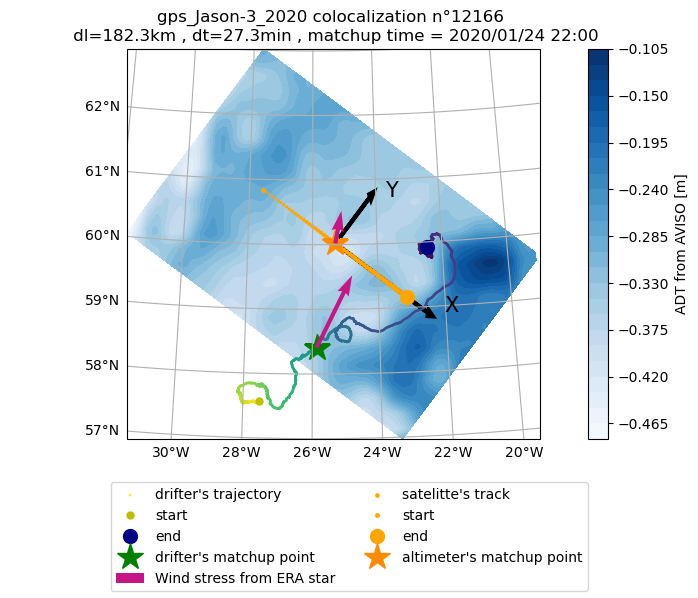

In [74]:
plot_coloc_matchup(l, 12166)

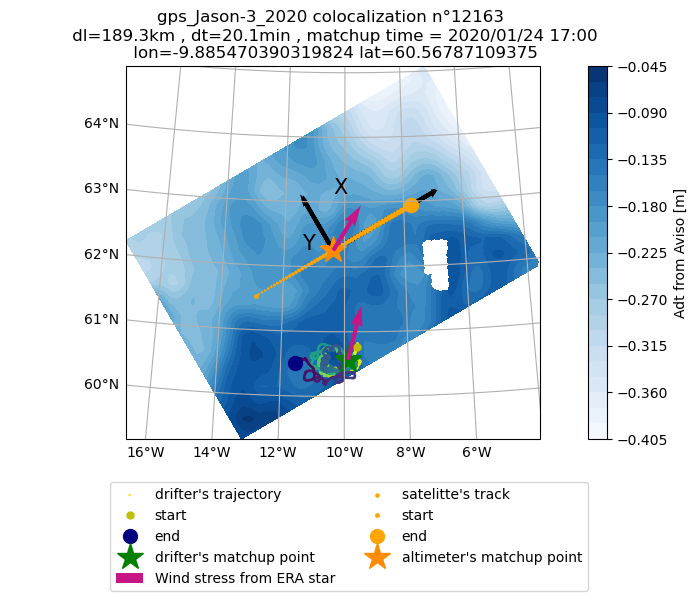

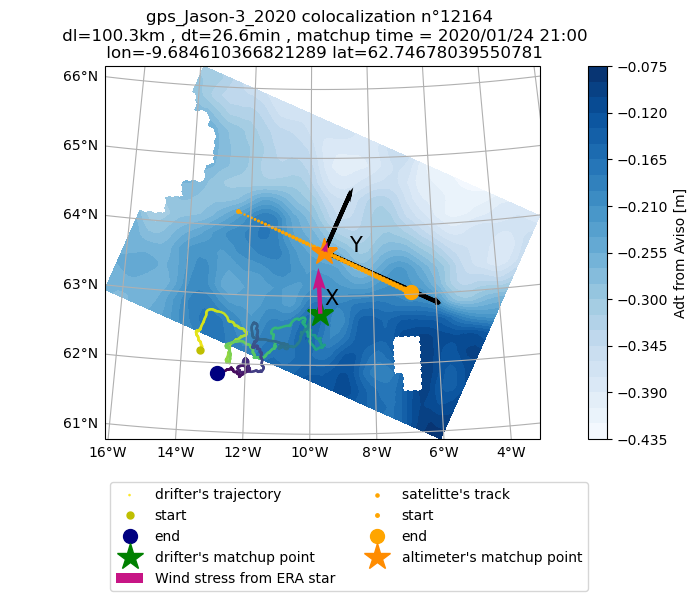

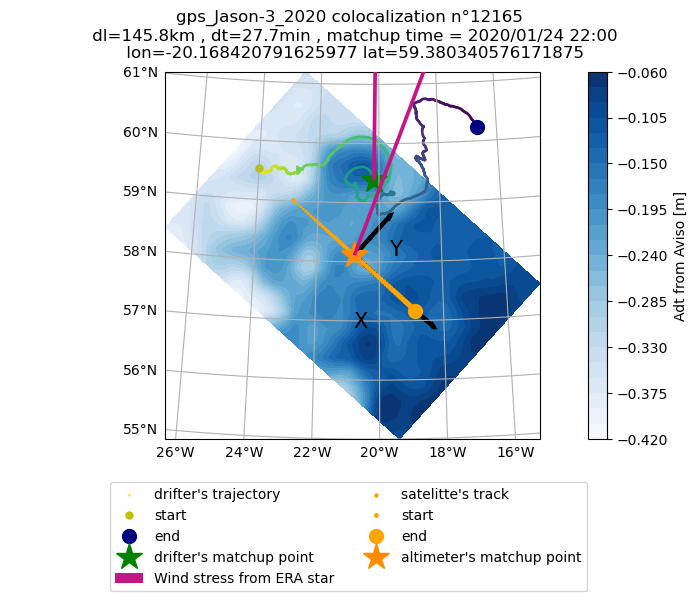

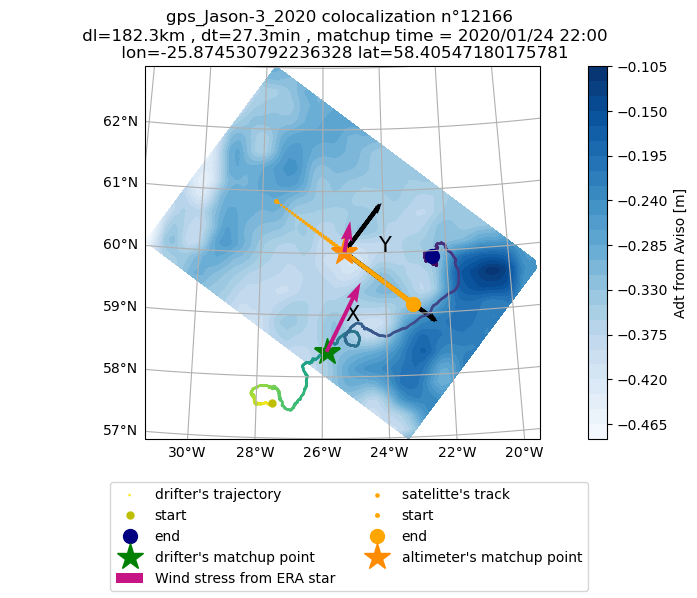

In [57]:
i = 10400
for nobs in dsm.obs.values[i:i+4] :
    plot_coloc_matchup(l, nobs)

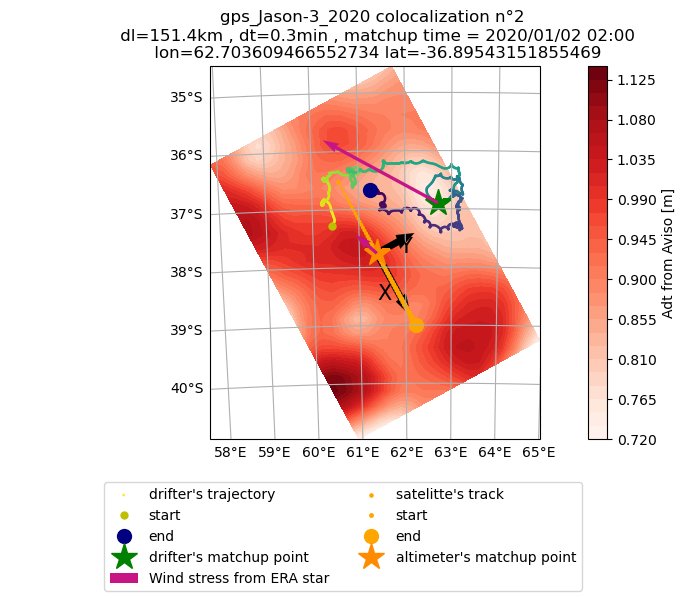

In [46]:
plot_coloc_matchup(l, 2)

3.325915638626604e-07 3.325915638626604e-07
-1.130981626972488e-07 -1.130981626972488e-07
1.7990598103887122e-07 1.7990598103887122e-07
-1.5174268526445783e-08 -1.5174268526445783e-08


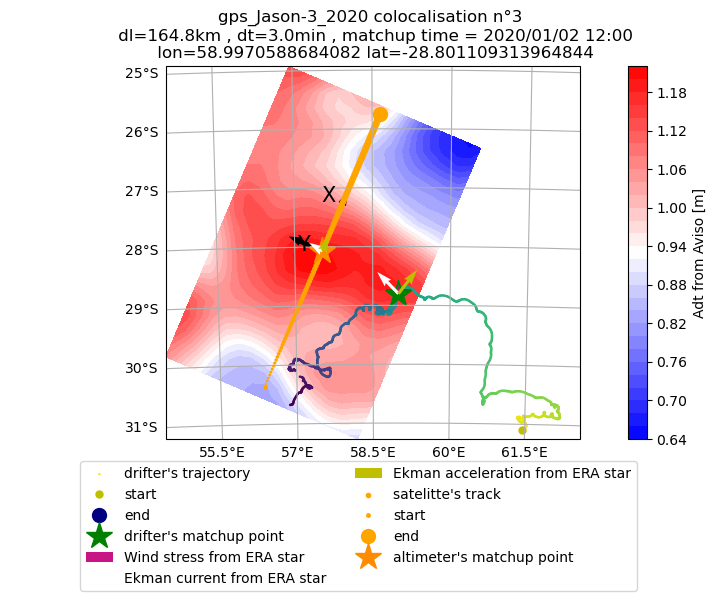

In [23]:
plot_coloc_matchup(l, 3)

5.323188358143954e-08 5.323188358143954e-08
-1.6588070984913833e-07 -1.6588070984913833e-07
4.4239363422215216e-08 4.4239363422215216e-08
-1.4261974104388597e-07 -1.4261974104388597e-07


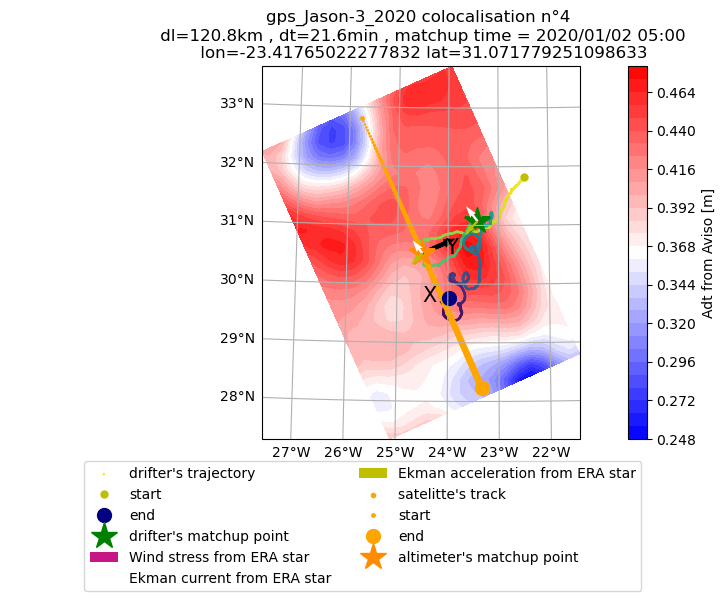

In [24]:
plot_coloc_matchup(l, 4)

-1.005323569852784e-06 -1.005323569852784e-06
8.450693802257622e-07 8.450693802257622e-07
-1.2303456635143153e-06 -1.2303456635143153e-06
8.961965480425057e-07 8.961965480425057e-07


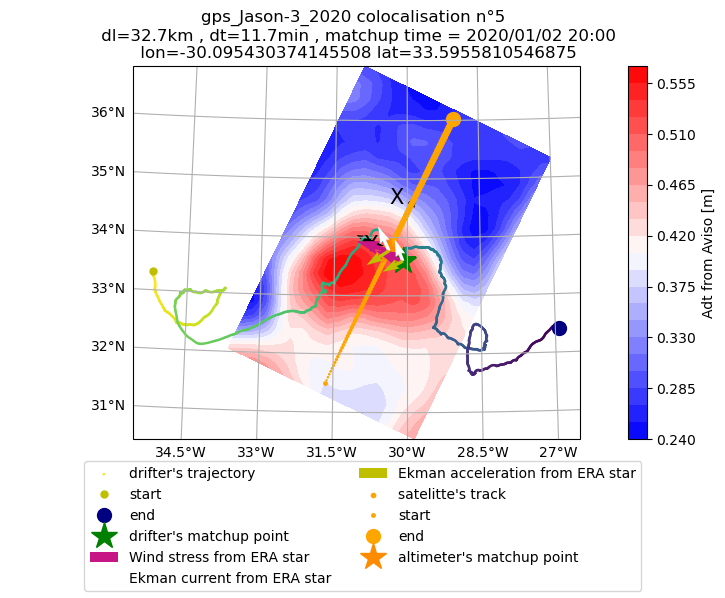

In [25]:
plot_coloc_matchup(l, 5)

-3.487240700294859e-07 -3.487240700294859e-07
3.401337534653411e-06 3.401337534653411e-06
-2.221742324235159e-07 -2.221742324235159e-07
3.4131465063025457e-06 3.4131465063025457e-06


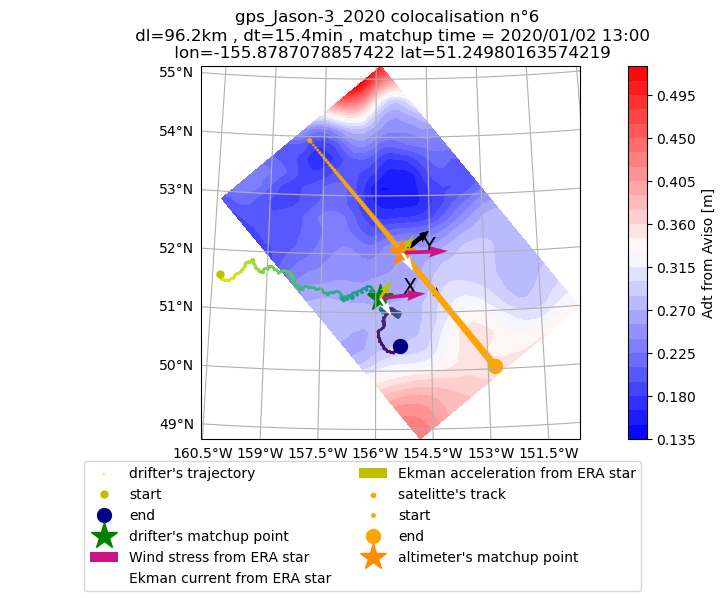

In [26]:
plot_coloc_matchup(l, 6)

In [28]:
ds_data.isel(obs=slice(0,10)).lat.compute()

<xarray.DataArray 'lat' (obs: 10)>
array([-41.17761993, -27.01383018, -36.89543152, -28.80110931,
        31.07177925,  33.59558105,  51.24980164,  30.40719986,
        52.29853821,  30.64699936])
Coordinates:
    lat      (obs) float64 -41.18 -27.01 -36.9 -28.8 ... 51.25 30.41 52.3 30.65
    lon      (obs) float64 139.0 -145.3 62.7 59.0 ... -59.59 -156.3 -24.16
  * obs      (obs) int64 0 1 2 3 4 5 6 7 8 9
    time     (obs) datetime64[ns] 2020-01-02T21:00:00 ... 2020-01-02T05:00:00
Attributes:
    long_name:      latitude of the nearest site data
    standard_name:  latitude

In [29]:
def plot_coloc_matchup_xy(label, nobs, dsm=dsm, ds_eras=ds_eras, ds_aviso=ds_aviso, ds_data=ds_data, figsize =(10,6), scaleera=1):
    #dataset
    _dsm = dsm.sel(obs=nobs).compute()
    dsoe = ds_eras.sel(obs=nobs).compute()
    dsdo = ds_data.sel(obs=nobs).compute()
    dsoa = ds_aviso.sel(obs=nobs).drop(['drifter_x', 'drifter_y', 'drifter_time']).compute()
    
    ## add ekman currents
    dsoe['es_drifter_matchup_ue'], dsoe['es_drifter_matchup_un'] = cst_rio_z15_currents(dsoe.es_drifter_matchup_taue, dsoe.es_drifter_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=False)
    dsoe['es_drifter_matchup_ux'], dsoe['es_drifter_matchup_uy'] = cst_rio_z15_currents(dsoe.es_drifter_matchup_taue, dsoe.es_drifter_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=True)
    dsoe['es_alti_matchup_ue'], dsoe['es_alti_matchup_un'] = cst_rio_z15_currents(dsoe.es_alti_matchup_taue, dsoe.es_alti_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=False)
    dsoe['es_alti_matchup_ux'], dsoe['es_alti_matchup_uy'] = cst_rio_z15_currents(dsoe.es_alti_matchup_taue, dsoe.es_alti_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=True)

    ## add ekman force in e,n
    dsoe['es_drifter_matchup_wd_e'], dsoe['es_drifter_matchup_wd_n'] = -dsdo.f*dsoe.es_drifter_matchup_un, dsdo.f*dsoe.es_drifter_matchup_ue
    dsoe['es_drifter_matchup_wd_x'], dsoe['es_drifter_matchup_wd_y'] = -dsdo.f*dsoe.es_drifter_matchup_uy, dsdo.f*dsoe.es_drifter_matchup_ux
    dsoe['es_alti_matchup_wd_e'], dsoe['es_alti_matchup_wd_n'] = -dsdo.f*dsoe.es_alti_matchup_un, dsdo.f*dsoe.es_alti_matchup_ue
    dsoe['es_alti_matchup_wd_x'], dsoe['es_alti_matchup_wd_y'] = -dsdo.f*dsoe.es_alti_matchup_uy, dsdo.f*dsoe.es_alti_matchup_ux
    
    ## add taux, tauy
    _ds = xr.merge([dsoe, dsdo, dsoa])

    lon, lat, t_matchup = float(_dsm.lon), float(_dsm.lat), _dsm.time.values
    td = pd.to_datetime(t_matchup)
    dt = float(_ds["alti___time_difference"])
    dl = float(_ds["alti___distance"])
    
    #figure
    fig, ax = plt.subplots(1,1,figsize=figsize)

    # aviso
    min_=abs(_ds["aviso_box_adt"].min())
    max_=abs(_ds["aviso_box_adt"].max())
    a=max(min_,max_)
    C=ax.contourf(_ds.box_x, _ds.box_y, _ds.aviso_box_adt, levels=30, cmap='bwr')

    #axes
    xc, yc=0,0
    ax_y=_ds.sel(box_x=0, box_y=50000)[['box_x', 'box_y']].compute()
    ax_x=_ds.sel(box_x=100000, box_y=0)[['box_x', 'box_y']].compute()
    x_x, x_y= ax_x.box_x,ax_x.box_y
    y_x, y_y= ax_y.box_x,ax_y.box_y
    ax.arrow(xc,yc, y_x-xc, y_y-yc, color='black', lw=3,head_width=10)
    ax.arrow(xc,yc, x_x-xc, x_y-yc, color='black', lw=3,head_width=10)
    ax.text(y_x, yc,'Y', fontsize=15)
    ax.text(xc, x_y,'X', fontsize=15)

    # drifter
    ax.scatter(_ds["drifter_x"], _ds["drifter_y"], c=np.arange(1, len(_ds["drifter_x"].values)+1),cmap='viridis_r', marker='.',s=3, label="drifter's trajectory")
    ax.plot(_ds["drifter_x"][0], _ds["drifter_y"][0], "o", ms=5, color="y",  label='start')
    ax.plot(_ds["drifter_x"][-1], _ds["drifter_y"][-1], "o", ms=10, color="navy",  label='end')

    ax.plot(_dsm["drifter_x"], _dsm["drifter_y"], 
            "*", ms=20, color="g", lw=2, label="drifter's matchup point")
    #eras
    #ax.quiver(np.array([_dsm["drifter_lon"],_ds["alti_lon"][45]]), np.array([_dsm["drifter_lat"],_ds["alti_lat"][45]]), np.array([_ds['es_drifter_matchup_taue'],_ds['es_alti_matchup_taue']]), np.array([_ds['es_drifter_matchup_taun'],_ds['es_alti_matchup_taun']]),
    #       color='mediumvioletred',transform=crs, lw=3, label='Wind stress from ERA star',scale=scaleera, width=0.01, zorder=4)
    ax.quiver(np.array([_dsm["drifter_x"],_ds["alti_x"][45]]), np.array([_dsm["drifter_y"],_ds["alti_y"][45]]), np.array([_ds['es_drifter_matchup_ux'],_ds['es_alti_matchup_ux']]), np.array([_ds['es_drifter_matchup_uy'],_ds['es_alti_matchup_uy']]),
             color='white', lw=3, label='Ekman current from ERA star', zorder=4)#scale=1e10, width=0.01,
    ax.quiver(np.array([_dsm["drifter_x"],_ds["alti_x"][45]]), np.array([_dsm["drifter_y"],_ds["alti_y"][45]]), np.array([_ds['es_drifter_matchup_wd_x'],_ds['es_alti_matchup_wd_x']]), np.array([_ds['es_drifter_matchup_wd_y'],_ds['es_alti_matchup_wd_y']]),
             color='y', lw=3, label='Ekman acceleration from ERA star', zorder=4)#scale=1e10, width=0.01,

    ax.set_title(label + f" colocalisation n°{nobs} \n dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time = "+td.strftime("%Y/%m/%d %H:%M")+f'\n lon={lon} lat={lat}')
    ax.set_ylim(-200000, 200000)
    ax.set_xlim(-300000, 300000)
    ax.set_aspect('equal')
    fig.legend(loc="lower center",  ncol=2, fontsize=10)
    fig.colorbar(C, label ='Adt from Aviso [m]')
    fig.tight_layout(rect=[0,0.2,1,1])
    
    return 1
    # altimetry
    ax.scatter(_ds["alti_lon"], _ds["alti_lat"], s=np.arange(1, len(_ds["alti_lon"].values)+1)*0.2, color="orange", transform=crs, label= "satelitte's track")
    ax.plot(_ds["alti_lon"][0], _ds["alti_lat"][0], ".", ms=5, color="orange", transform=crs, label='start')
    ax.plot(_ds["alti_lon"][-1], _ds["alti_lat"][-1], ".", ms=20, color="orange", transform=crs,label='end')
    ax.plot(_ds["alti_lon"][45], _ds["alti_lat"][45], "*", ms=20, color="darkorange", lw=2, transform=crs, label="altimeter's matchup point")
    
    gl = ax.gridlines(draw_labels=True, dms=False, 
                 x_inline=False, y_inline=False, 
                )
    gl.right_labels=False
    gl.top_labels=False

    ax.set_title(label + f" colocalisation n°{nobs} \n dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time = "+td.strftime("%Y/%m/%d %H:%M")+f'\n lon={lon} lat={lat}')
    ax.set_ylim(-200000, 200000)
    ax.set_xlim(-300000, 300000)
    fig.legend(loc="lower center",  ncol=2, fontsize=10)
    fig.colorbar(C, label ='Adt from Aviso [m]')
    fig.tight_layout(rect=[0,0.2,1,1])
    
    #images_dir = "/home1/datahome/mdemol/m2_2022/images/"

    #fig.savefig(images_dir+f'label0_nobs{nobs}.png', dpi=200)

1

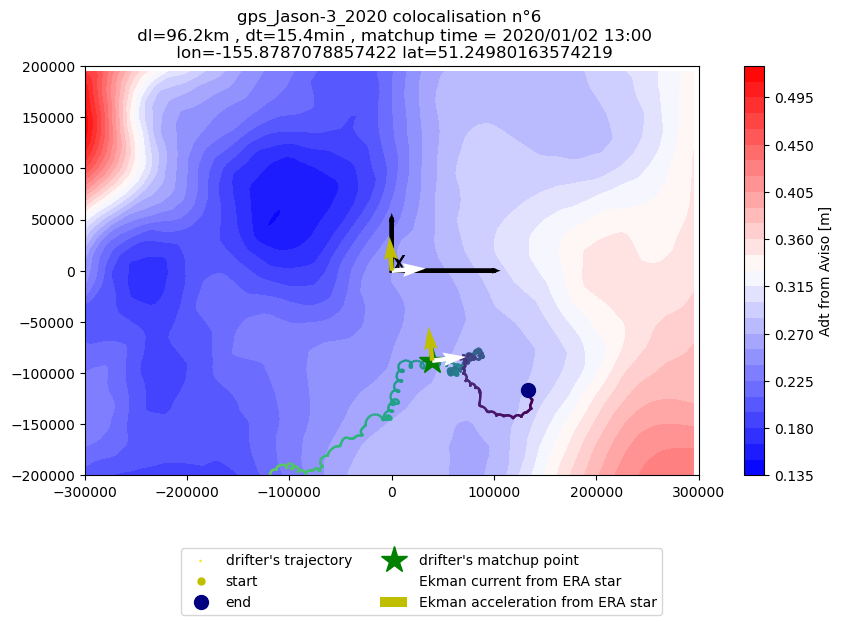

In [30]:
plot_coloc_matchup_xy(l, 6)

1

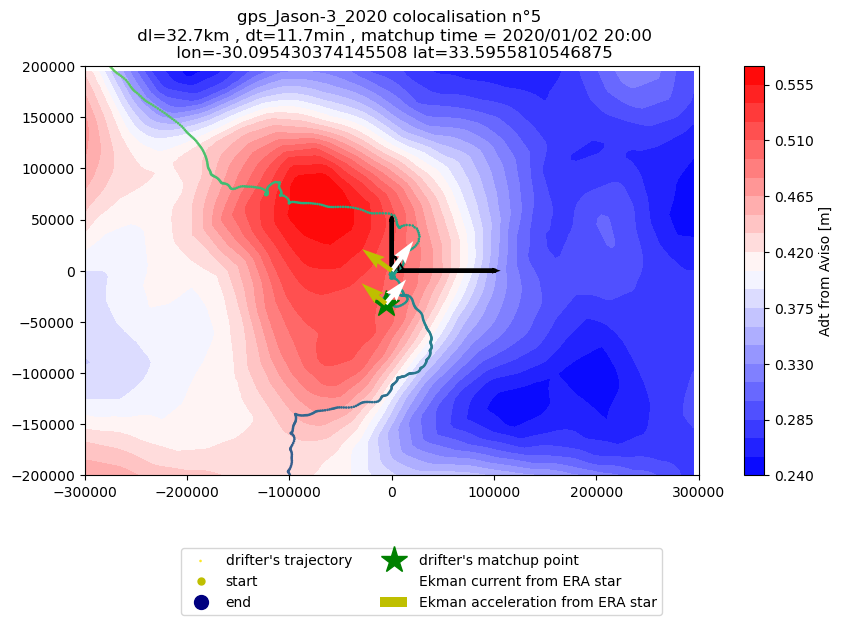

In [31]:
plot_coloc_matchup_xy(l, 5)

1

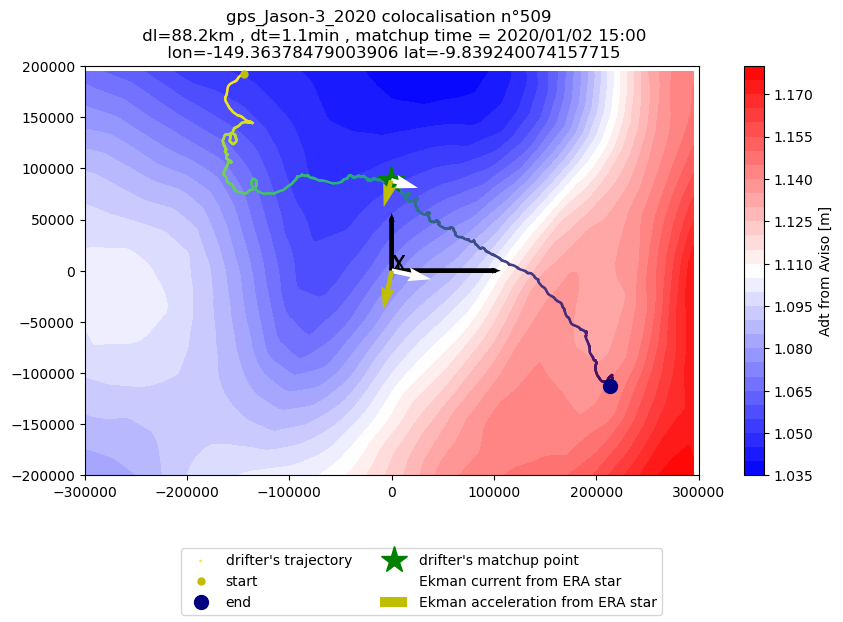

In [32]:
plot_coloc_matchup_xy(l, 509)

1

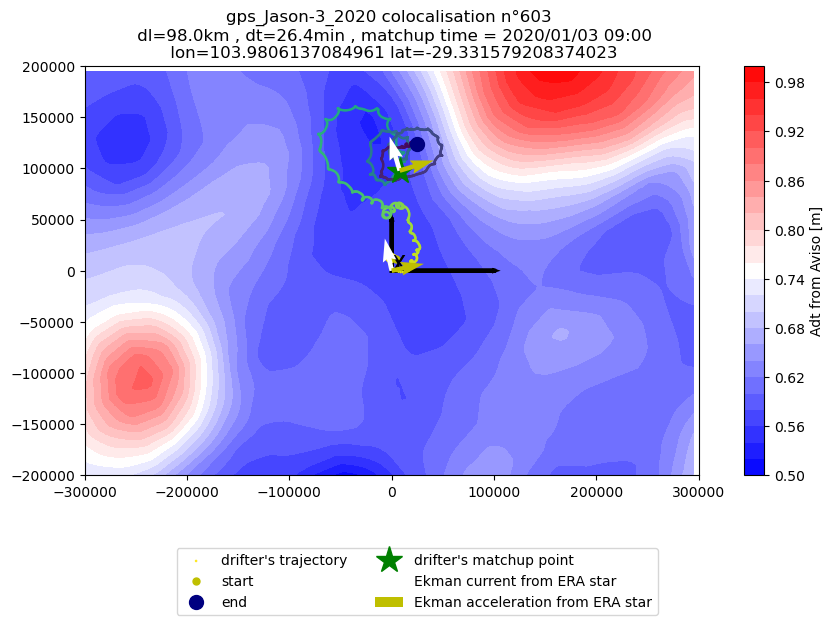

In [33]:
plot_coloc_matchup_xy(l, 603)

## Check same as in matchup file

In [34]:
dsmm = xr.open_zarr(os.path.join(zarr_dir+'_ok', f'matchup/matchup_{l}.zarr'))

In [35]:
dsm.es_cstrio_z15_alti_wd_x

<xarray.DataArray 'es_cstrio_z15_alti_wd_x' (obs: 36694)>
dask.array<mul, shape=(36694,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>
Coordinates:
  * obs                     (obs) int64 0 2 3 4 5 ... 43068 43069 43071 43072
    alti___distance         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___time_difference  (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lat                     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                    (obs) datetime64[ns] dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    long_name:    $(-\frac{1}{\rho}\partial_z\tau_x)_{altimatchup}$ from cstr...
    description:  along track wind related term interpolated at the altimeter...
    units:        $m.s^{-2}$

In [36]:
np.all(dsmm.es_cstrio_z15_alti_wd_x==dsm.es_cstrio_z15_alti_wd_x).compute()

<xarray.DataArray 'es_cstrio_z15_alti_wd_x' ()>
array(False)

In [37]:
np.all(dsmm.es_cstrio_z15_alti_wd_y==dsm.es_cstrio_z15_alti_wd_y).compute()

<xarray.DataArray 'es_cstrio_z15_alti_wd_y' ()>
array(False)

In [38]:
np.all(dsmm.es_cstrio_z15_drifter_wd_x==dsm.es_cstrio_z15_drifter_wd_x).compute()

<xarray.DataArray 'es_cstrio_z15_drifter_wd_x' ()>
array(True)

In [39]:
np.all(dsmm.es_cstrio_z15_drifter_wd_y==dsm.es_cstrio_z15_drifter_wd_y).compute()

<xarray.DataArray 'es_cstrio_z15_drifter_wd_y' ()>
array(True)